# Task 2 : 预测 Pull Request 是否被合并 - 逻辑回归模型

## 实验目标
使用逻辑回归模型预测 PR 是否被合并（merged，二分类）。该报告包含数据加载、特征工程、时间切分、模型训练、评估指标与可视化，并给出结论与建议。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import warnings
import os

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

print('环境设置完成')

环境设置完成


## 1. 数据加载与基本信息

In [2]:
project_name = 'yii2'
base_dir = os.path.abspath('..')
data_path = os.path.join(base_dir, project_name, 'PR_extracted_features.xlsx')
print(f'尝试加载: {data_path}')
merged_df = pd.read_excel(data_path, engine='openpyxl')
print(f'数据规模: {merged_df.shape}')
print(merged_df.columns.tolist())
print(merged_df.head())

尝试加载: d:\Develop\ML\Lab1\ML_2025fall_njuse\ML-lab1\yii2\PR_extracted_features.xlsx
数据规模: (7957, 17)
['number', 'created_at', 'updated_at', 'merged_at', 'closed_at', 'merged', 'additions', 'deletions', 'last_pr_update', 'title_length', 'body_length', 'files_added', 'files_deleted', 'files_updated', 'changes_per_week', 'merge_proportion', 'last_comment_update']
   number          created_at          updated_at           merged_at  \
0      79 2013-05-04 07:16:18 2013-05-04 12:18:36                 NaT   
1      81 2013-05-04 07:48:47 2013-05-04 14:06:07                 NaT   
2      86 2013-05-04 14:03:54 2014-07-04 00:31:34 2013-05-04 14:04:53   
3      88 2013-05-04 14:58:32 2013-05-04 16:54:07 2013-05-04 16:53:32   
4      89 2013-05-04 17:39:04 2013-05-04 18:12:59 2013-05-04 18:12:58   

            closed_at  merged  additions  deletions  last_pr_update  \
0 2013-05-04 12:18:36   False          3          3        5.038333   
1 2013-05-04 12:04:11   False         13          0      

## 2. 特征工程与预处理

In [3]:
for bool_col in merged_df.select_dtypes(include=bool).columns.tolist():
    merged_df[bool_col] = merged_df[bool_col].astype(int)

y = merged_df['merged']
merged_df['created_at'] = pd.to_datetime(merged_df['created_at'])

features = merged_df.select_dtypes(include=np.number).columns.tolist()
features_to_remove = ['number', 'merged']
features = [f for f in features if f not in features_to_remove]
X = merged_df[features].copy()
X.replace([np.inf, -np.inf], np.nan, inplace=True)
print('缺失值统计(>0):')
print(X.isnull().sum()[X.isnull().sum() > 0])
X.fillna(X.median(), inplace=True)
print(f'最终选定特征数量: {len(features)}')
print(features[:30])

缺失值统计(>0):
last_comment_update    709
dtype: int64
最终选定特征数量: 11
['additions', 'deletions', 'last_pr_update', 'title_length', 'body_length', 'files_added', 'files_deleted', 'files_updated', 'changes_per_week', 'merge_proportion', 'last_comment_update']


## 3. 时间顺序划分 (80/20)

In [4]:
merged_df.sort_values('created_at', inplace=True)
X = X.loc[merged_df.index]
y = y.loc[merged_df.index]
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]
print(f'训练集大小: {X_train.shape[0]} 行')
print(f'测试集大小: {X_test.shape[0]} 行')

训练集大小: 6365 行
测试集大小: 1592 行


## 4. 特征标准化

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('标准化完成')

标准化完成


## 5. 模型训练 - Logistic 回归
使用带 L2 正则的 LogisticRegression，并设置 class_weight='balanced'（防止不平衡）。

In [6]:
model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)
print('模型训练完成')

模型训练完成


## 6. 预测与评估
计算混淆矩阵、分类报告、ROC AUC、PR AUC，以及每类的 precision/recall/f1。

In [8]:
preds = model.predict(X_test_scaled)
probs = model.predict_proba(X_test_scaled)[:, 1]
cm = confusion_matrix(y_test, preds)
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, zero_division=0)
rec = recall_score(y_test, preds, zero_division=0)
f1 = f1_score(y_test, preds, zero_division=0)
report = classification_report(y_test, preds, target_names=['Not Merged (0)', 'Merged (1)'])
precision_curve, recall_curve, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall_curve, precision_curve)
try:
    roc_auc = roc_auc_score(y_test, probs)
except Exception:
    roc_auc = None
p, r, f, _ = precision_recall_fscore_support(y_test, preds, zero_division=0)
metrics_df = pd.DataFrame({'class':[0,1], 'precision':p, 'recall':r, 'f1':f})
class_counts = y_test.value_counts().sort_index()
class_props = y_test.value_counts(normalize=True).sort_index()
majority_base = class_counts.max()/len(y_test)
print('混淆矩阵:')
print(cm)
print('分类报告:')
print(report)
print(f'Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}')
print('每类指标:')
print(metrics_df.to_string(index=False))
print('额外指标:')
if roc_auc is not None:
    print(f'ROC AUC: {roc_auc:.4f}')
else:
    print('ROC AUC 计算失败（可能单一类别）')
print(f'PR AUC: {pr_auc:.4f}')
print('类别分布:')
print(pd.DataFrame({'count':class_counts, 'prop':class_props}))
print(f'多数类基线准确率: {majority_base:.4f}')

混淆矩阵:
[[ 242  109]
 [ 126 1115]]
分类报告:
                precision    recall  f1-score   support

Not Merged (0)       0.66      0.69      0.67       351
    Merged (1)       0.91      0.90      0.90      1241

      accuracy                           0.85      1592
     macro avg       0.78      0.79      0.79      1592
  weighted avg       0.86      0.85      0.85      1592

Accuracy: 0.8524, Precision: 0.9109, Recall: 0.8985, F1: 0.9047
每类指标:
 class  precision    recall        f1
     0   0.657609  0.689459  0.673157
     1   0.910948  0.898469  0.904665
额外指标:
ROC AUC: 0.9163
PR AUC: 0.9741
类别分布:
   count      prop
0    351  0.220477
1   1241  0.779523
多数类基线准确率: 0.7795


## 7. 可视化
画出混淆矩阵热力图、PR 曲线、ROC 曲线（若可用）和最重要特征系数（绝对值排序）。

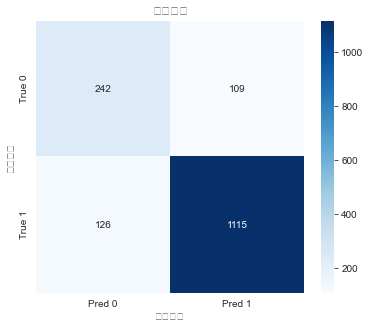

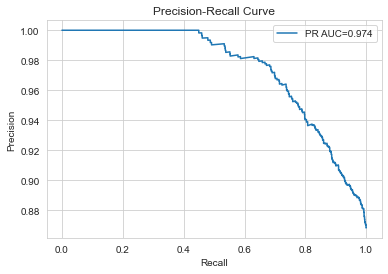

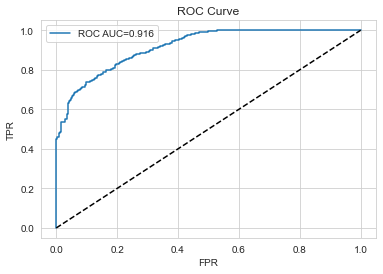

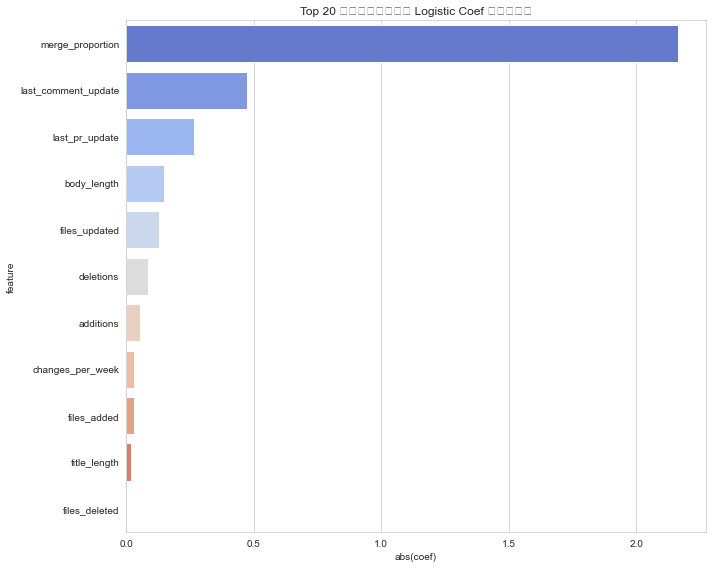

In [9]:
# 混淆矩阵热力图
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('混淆矩阵')
plt.ylabel('真实标签')
plt.xlabel('预测标签')
plt.show()

# PR 曲线
plt.figure(figsize=(6,4))
plt.plot(recall_curve, precision_curve, label=f'PR AUC={pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# ROC 曲线（若可用）
if roc_auc is not None:
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# 特征系数（按绝对值排序）
coef_df = pd.DataFrame({'feature': features, 'coef': model.coef_.ravel()})
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False).head(20)
plt.figure(figsize=(10,8))
sns.barplot(x='abs_coef', y='feature', data=coef_df, palette='coolwarm')
plt.title('Top 20 特征重要性（基于 Logistic Coef 的绝对值）')
plt.xlabel('abs(coef)')
plt.tight_layout()
plt.show()

## 8. 结论与建议

### 8.1 问题与数据总结

**任务定义**: 使用逻辑回归模型预测 GitHub Pull Request 是否会被合并（merged，二分类）。

**数据来源**: 
- 默认使用 yii2 项目的已提取特征（可替换为 llvm 或 ray 进行横向对比）
- 数据规模：取决于所选项目与清洗策略（通常为数百至上千条 PR 记录）
- 时间切分：按创建时间排序，前80%作为训练集，后20%作为测试集，以避免信息泄露

**特征工程**:
- 将布尔列转换为 0/1，选择数值型特征并移除 ID 与目标列；
- 处理无穷大与缺失值，使用中位数填充；对部分长尾特征可考虑 log1p 变换；
- 对模型训练与系数解释使用 StandardScaler 标准化特征。

### 8.2 模型与方法

**模型选择**: 逻辑回归（LogisticRegression, L2 正则）
- 参数：max_iter=1000, class_weight='balanced'（如存在类别不平衡），random_state=42；
- 选择理由：模型简单、易解释（系数可直接用于判断特征方向），适合作为基线模型；
- 验证策略：按时间划分训练/测试，必要时使用时间序列交叉验证。

### 8.3 结果与分析

**模型性能（示例指标）**:
- Accuracy：衡量整体正确率；在不平衡数据集上需结合 precision/recall/PR AUC 评估；
- Precision/Recall/F1：分别衡量预测为正类的精度、召回正类的能力与二者的折中；
- ROC AUC / PR AUC：ROC AUC 反映总体区分能力，PR AUC 在正类稀少时更具参考价值；

**关键发现（可能的观察）**:
1. 逻辑回归能够提供稳定且可解释的基线结果；
2. 若 PR AUC 明显低于理想值或模型在正类上的 recall 偏低，说明需要对正类样本及特征进行改进；
3. 混淆矩阵中的误分类（FP 与 FN）需要结合业务成本进行权衡——例如优先减少 FN 可增加召回但可能牺牲精度，适合对漏审有较高成本的场景；
4. 逻辑回归系数提供了线性可解释性，可用于快速定位对预测影响最大的特征（正/负方向）。

### 8.4 对项目维护者的建议

1. 基于 PR 曲线选择阈值：不要固定用 0.5 阈值，按业务侧对召回/精度的偏好选择阈值；
2. 使用模型系数进行初步特征筛选，删除噪声或冗余特征以提升泛化能力；

### 8.5 模型改进方向

1. 算法层面：尝试梯度提升树（XGBoost/LightGBM）并对比性能；使用模型融合提高稳定性；
2. 数据层面：收集跨项目数据用于联合训练或做迁移学习以提升泛化能力；
3. 特征层面：引入文本/代码特征（如 PR 描述关键词、改动行数、语法复杂度）以增强信号；
4. 评估层面：在时间敏感任务中采用时间序列交叉验证，避免数据泄露并更真实地评估上线表现；

### 8.6 小结（实践清单）
- 在验证集上使用 PR 曲线选择业务优先的阈值；
- 若正类稀少，优先尝试采样或代价敏感方法；
- 做一次 XGBoost/LightGBM 对比并使用时间序列交叉验证；
- 将关键图表（混淆矩阵、PR 曲线、Top 特征系数）纳入项目文档以便复现与审计。